In [10]:
from google.transit import gtfs_realtime_pb2
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
import zipfile
from pathlib import Path
import py7zr
import csv

LINES_NAME = 'tvarbanan'
LINES_NAME = 'caner-pendeltåg'

## Read in GTFS Static Data

/Users/ivo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


,stop_id,stop_name,geometry
10572,9022001005111001,Rosersberg,POINT (17.88023 59.58304)
10573,9022001005111002,Rosersberg,POINT (17.88023 59.58303)
10574,9022001005121001,Märsta,POINT (17.86095 59.62766)
10575,9022001005121002,Märsta,POINT (17.86095 59.62771)
10917,9022001005031002,Solna,POINT (18.00961 59.36650)


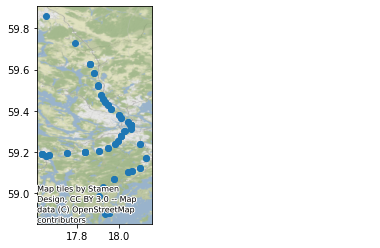

In [11]:
# Stops selected for Tvärbanan
stops = pd.read_csv(f"""./data/2-working-data/{LINES_NAME}-stops.csv""", index_col=0)
stops.stop_id = stops.stop_id.astype(str)

# Change to GeoDataFrame
stops['geometry'] = stops.apply(lambda x: Point(x.stop_lon, x.stop_lat), axis=1)
stops = stops.drop(columns=['location_type', 'stop_lat', 'stop_lon', 'platform_code', 'parent_station'])
stops = gpd.GeoDataFrame(stops, crs='EPSG:4326')

# Plot out and show stops
ax = stops.plot()
cx.add_basemap(ax, crs=stops.crs)

stops.head()

## Read in all TripUpdates

In [12]:
# Collect all the days in the different months
days = glob("./data/0-koda-gtfs-rt/tu/2021-06-*.7z")[:14]

# Sample
days = ['./data/0-koda-gtfs-rt/tu/2021-06-21.7z',
        './data/0-koda-gtfs-rt/tu/2021-06-22.7z',
        './data/0-koda-gtfs-rt/tu/2021-06-23.7z',
        './data/0-koda-gtfs-rt/tu/2021-06-24.7z',
        './data/0-koda-gtfs-rt/tu/2021-06-25.7z']

days[:5], len(days)

(['./data/0-koda-gtfs-rt/tu/2021-06-21.7z',
  './data/0-koda-gtfs-rt/tu/2021-06-22.7z',
  './data/0-koda-gtfs-rt/tu/2021-06-23.7z',
  './data/0-koda-gtfs-rt/tu/2021-06-24.7z',
  './data/0-koda-gtfs-rt/tu/2021-06-25.7z'],
 5)

In [14]:
iterator = tqdm(days)
for day in iterator:

    path = day.split('/')[4]
    out = f"""TU-{LINES_NAME}-{path[:4]}{path[5:7]}{path[8:10]}"""
    out_path = f"""./data/3-cleaned-data/{out}.csv"""
    
    if os.path.exists(out_path):
        print(out+" exists.")
        continue
    
    with py7zr.SevenZipFile(day, 'r') as archive:
        allfiles = archive.getnames()
        targets = [f for f in allfiles if f.endswith('.pb')]
        iterator.set_description(f"""{out}: Unpacking {len(targets)} files""")
        files = archive.read(targets)

    iterator.set_description(f"""{out}: Reading""")
    tu_data = []
    for target in tqdm(targets, leave=False):

        feed = gtfs_realtime_pb2.FeedMessage()
        feed.ParseFromString(files[target].read())

        for e in feed.entity: 
            tu_data += [
                (e.trip_update.timestamp, 
                 e.trip_update.trip.trip_id,
                 e.trip_update.trip.schedule_relationship,
                 stop_update.stop_id,
                 stop_update.arrival.time, 
                 stop_update.arrival.delay, 
                 stop_update.departure.time,
                 stop_update.departure.delay)
                for stop_update in e.trip_update.stop_time_update
                if stop_update.stop_id in stops.stop_id.to_list()
        ]
    
    iterator.set_description(f"""{out}: Writing CSV with {len(tu_data)} lines""")
    # Incorporate collected data into DataFrame.
    tu_df = pd.DataFrame(tu_data, columns=['timestamp', 'trip_id', 'rel', 'stop_id', 
                                        'arrival_ts', 'arrival_delay', 
                                        'departure_ts', 'departure_delay'])

    tu_df.to_csv(out_path)
    
    del tu_df
    del tu_data

  0%|          | 0/5 [00:00<?, ?it/s]

TU-caner-pendeltåg-20210621 exists.


  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/4698 [00:00<?, ?it/s]

  0%|          | 0/4721 [00:00<?, ?it/s]

  0%|          | 0/4916 [00:00<?, ?it/s]